In [1]:
import Pkg; Pkg.activate(@__DIR__)
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using MeshCat, GeometryBasics, Colors, CoordinateTransformations, Rotations
using Plots
using BilinearControl
using BilinearControl.EDMD
using FileIO, JLD2

  Activating environment at `~/.julia/dev/BilinearControl/examples/Project.toml`


In [2]:
ref_traj = FileIO.load("../data/cartpole_reference_trajectory.jld2")
X_sim = ref_traj["X_sim"][1:601]
U_sim = ref_traj["U_sim"][1:600]
T_sim = ref_traj["T_sim"][1:601]

601-element Vector{Float64}:
 0.0
 0.005
 0.01
 0.015
 0.02
 0.025
 0.03
 0.035
 0.04
 0.045
 0.05
 0.055
 0.06
 ⋮
 2.945
 2.95
 2.955
 2.96
 2.965
 2.97
 2.975
 2.98
 2.985
 2.99
 2.995
 3.0

In [3]:
const RD = RobotDynamics

RobotDynamics

In [4]:
function defcolor(c1, c2, c1def, c2def)
    if !isnothing(c1) && isnothing(c2)
        c2 = c1
    else
        c1 = isnothing(c1) ? c1def : c1
        c2 = isnothing(c2) ? c2def : c2
    end
    c1,c2
end

function set_mesh!(vis0, model::RobotZoo.Cartpole; 
        color=nothing, color2=nothing)
    vis = vis0["robot"]
    dim = Vec(0.1, 0.3, 0.1)
    rod = Cylinder(Point3f0(0,-10,0), Point3f0(0,10,0), 0.01f0)
    cart = Rect3D(-dim/2, dim)
    hinge = Cylinder(Point3f0(-dim[1]/2,0,dim[3]/2), Point3f0(dim[1],0,dim[3]/2), 0.03f0)
    c1,c2 = defcolor(color,color2, colorant"blue", colorant"red")

    pole = Cylinder(Point3f0(0,0,0),Point3f0(0,0,model.l),0.01f0)
    mass = HyperSphere(Point3f0(0,0,model.l), 0.05f0)
    setobject!(vis["rod"], rod, MeshPhongMaterial(color=colorant"grey"))
    setobject!(vis["cart","box"],   cart, MeshPhongMaterial(color=isnothing(color) ? colorant"green" : color))
    setobject!(vis["cart","hinge"], hinge, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["cart","pole","geom","cyl"], pole, MeshPhongMaterial(color=c1))
    setobject!(vis["cart","pole","geom","mass"], mass, MeshPhongMaterial(color=c2))
    settransform!(vis["cart","pole"], Translation(0.75*dim[1],0,dim[3]/2))
end

function visualize!(vis, model::RobotZoo.Cartpole, x::StaticVector)
    y = x[1]
    θ = x[2]
    q = expm((pi-θ) * @SVector [1,0,0])
    settransform!(vis["robot","cart"], Translation(0,-y,0))
    settransform!(vis["robot","cart","pole","geom"], LinearMap(UnitQuaternion(q)))
end

function visualize!(vis, model::RobotDynamics.AbstractModel, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    n = state_dim(model)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize!(vis, model, SVector{n}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 2 methods)

In [5]:
function simulate(dmodel, x0, U, dt)

    t = 0.0
    x = x0
    X = [x]
    T = [t]
    
    for k in 1:length(U)

        u = U[k]
        x = RD.discrete_dynamics(dmodel, x, u, t, dt)
        t += dt
        push!(X, x)
        append!(T, t)

    end

    return T, X

end

function simulate_bilinear(F, C, g, x0, z0, U)
    
    x = x0
    z = z0
    Z = [z]
    X = [x]

    for k in 1:length(U)

        u = U[k]
        
        z = F * z + (C * z) .* u
        x = g * z

        push!(Z, z)
        push!(X, x)
        
    end

    return X, Z

end

simulate_bilinear (generic function with 1 method)

In [6]:
# define temporal properties
dt = T_sim[2]-T_sim[1]
tf = T_sim[end]

num_knots = Int(tf/dt + 1)

# define pendulum initial properties
x0 = X_sim[1]

# define Pendulum model
model = RobotZoo.Cartpole(1.0, 0.2, 0.5, 9.81)

state_dim(model) = 4
control_dim(model) = 1

dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
n, m = RD.dims(dmodel)

(4, 1, 4)

In [7]:
# determine eigenfunction state values
eigfuns = ["state", "sine", "cosine"]
eigorders = [0,0,0]
Z_sim, Zu_sim, z0 = build_eigenfunctions(X_sim, U_sim, eigfuns, eigorders)

# learn bilinear model
F, C, g = learn_bilinear_model(X_sim, Z_sim, Zu_sim, ["lasso", "lasso"]; edmd_weights=[0.0], mapping_weights=[0.0])

([1.0000000000003628 1.0635060394147657e-12 … -6.4217733528681e-14 3.393620799734772e-15; 0.00011371926243328908 0.9991349513772658 … -1.1673149763238735e-5 8.196213959433251e-7; … ; -0.012091899658090762 0.24874939682412792 … 0.984019426805042 -0.0003207380332589334; 5.793404927981355 -31.628345542618064 … 0.4883247909868902 0.9350875005585539], [-2.1038988863765421e-13 6.957366111105048e-13 … -5.541207970495989e-15 5.347980831820177e-16; 3.197285579964159e-5 5.275725780822068e-5 … -9.694601306397299e-7 7.583730504949801e-8; … ; 0.037534271684977076 -0.09102992678025619 … 0.00044649394027822134 5.88128588955099e-5; -0.7516078211512003 3.751439142992379 … -0.03588800814569249 0.0021410686224791298], [-1.4038141714434935e-13 1.0000000000004954 … -7.587765405927197e-15 5.623540073320806e-16; 2.452681211520077e-14 -1.2058801040238493e-13 … 1.407765644995062e-15 -6.470006970132172e-16; -8.97839897583601e-16 3.09276486510803e-15 … -1.577405019525415e-16 1.463056282250841e-16; -9.97746589973

In [8]:
bi_X, _ = simulate_bilinear(F, C, g, x0, z0, U_sim)

([[0.0, 0.0, 0.0, 0.0], [4.469409344335327e-5, -8.99121274201992e-5, 0.017878091790108915, -0.03596253180201371], [0.00017541927287995857, -0.0003527399228851264, 0.034413315319309065, -0.06916829708434988], [0.0003834166890377873, -0.0007704663360925708, 0.048788139112223995, -0.09792594042465838], [0.000659505347738622, -0.0013240792613994534, 0.06165034059839415, -0.12352444986221896], [0.0010336708397218062, -0.002074204185534554, 0.08801130503029227, -0.17649109221082576], [0.0015305231905937244, -0.0030703918511750987, 0.11072735620256682, -0.22195740632906708], [0.0021373950344208206, -0.004286341529237831, 0.13201976538231291, -0.2643968411674044], [0.002840366069009411, -0.005692947247507526, 0.1491683245589843, -0.2982256292859218], [0.003663649215476987, -0.0073388113568972945, 0.18014009413147586, -0.3600706437227892]  …  [0.013393550217844939, 3.1907951193938597, 0.02023879732862281, 0.048832172408617834], [0.013499613312868815, 3.191047514871824, 0.02218670262020938, 0.05

In [9]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8701))

In [10]:
visualize!(vis, model, tf, bi_X)

In [11]:
visualize!(vis, model, tf, X_sim)

In [12]:
# extract individual state histories
X_mat = mapreduce(permutedims, vcat, X_sim)'
bi_X_mat = mapreduce(permutedims, vcat, bi_X)'

cart_pos = X_mat[1, :]
pend_angle = X_mat[2, :]
cart_vel = X_mat[3, :]
pend_angular_vel = X_mat[4, :]

cart_pos_bilinear = bi_X_mat[1, :]
pend_angle_bilinear = bi_X_mat[2, :]
cart_vel_bilinear = bi_X_mat[3, :]
pend_angular_vel_bilinear = bi_X_mat[4, :]

601-element Vector{Float64}:
  0.0
 -0.03596253180201371
 -0.06916829708434988
 -0.09792594042465838
 -0.12352444986221896
 -0.17649109221082576
 -0.22195740632906708
 -0.2643968411674044
 -0.2982256292859218
 -0.3600706437227892
 -0.4122646538875526
 -0.45989611888387427
 -0.5006392294314154
  ⋮
  0.04572661414092735
  0.04822613828519194
  0.048832172408617834
  0.05212755479420897
  0.05472144708174323
  0.05834222497955246
  0.06068214670479767
  0.06197107838801042
  0.0637963244798722
  0.06529801074703029
  0.06873024232375434
  0.0691293785590519

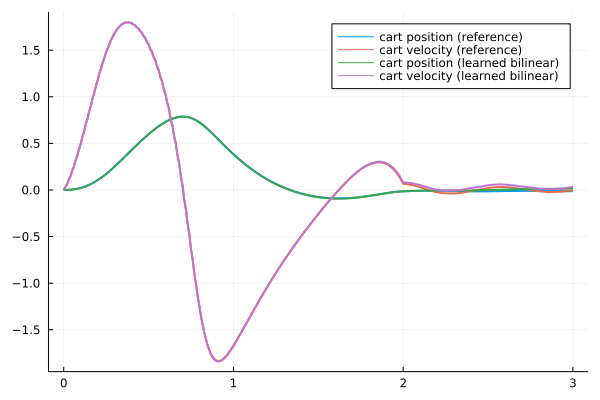

In [13]:
plot(T_sim, cart_pos, label = "cart position (reference)", lw = 2)
plot!(T_sim, cart_vel, label = "cart velocity (reference)",lw = 2)

plot!(T_sim, cart_pos_bilinear, label = "cart position (learned bilinear)", lw = 2)
plot!(T_sim, cart_vel_bilinear, label = "cart velocity (learned bilinear)", lw = 2)

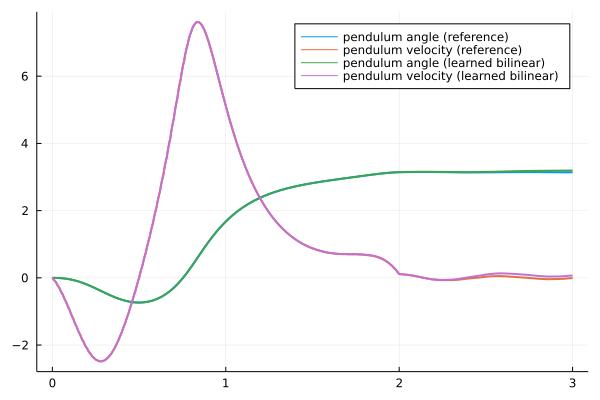

In [14]:
plot(T_sim, pend_angle, label = "pendulum angle (reference)", lw = 2)
plot!(T_sim, pend_angular_vel, label = "pendulum velocity (reference)",lw = 2)

plot!(T_sim, pend_angle_bilinear, label = "pendulum angle (learned bilinear)", lw = 2)
plot!(T_sim, pend_angular_vel_bilinear, label = "pendulum velocity (learned bilinear)", lw = 2)

In [15]:
# FileIO.save("../data/cartpole_eDMD_data.jld2", "F", F, "C", C, "g", g, "X_sim", X_sim, "U_sim", U_sim, "Z_sim", Z_sim, "Zu_sim", Zu_sim)
jldsave(joinpath(@__DIR__, "../data/cartpole_eDMD_data.jld2"); F, C, g, X_ref, U_ref, T_ref, eigfuns, eigorders)